<a href="https://colab.research.google.com/github/bksaini078/fake_news_detection/blob/master/MeanTeacher/MT_Dropouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author : Bhupender Kumar Saini**
Performing drop out of words in the file.

# Declaring Libraries 





In [ ]:
#please install contractions 
import numpy as np
import re
import nltk
# import contractions
import string
import pandas as pd
import os
import numpy as np

import random
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

import spacy
import time
import re

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils 
from gensim.test.utils import get_tmpfile
from nltk.corpus import stopwords
import nltk
import en_core_web_sm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

# nlp = en_core_web_sm.load()
# nltk.download('stopwords')
# nltk.download('punkt')
# porter=PorterStemmer()


In [ ]:
import tensorflow as tf 

import tensorflow.keras as tfk
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
import numpy as np
import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
#this is to enable eager execution
tf.compat.v1.enable_eager_execution()

# provide path of .npy files
path='/content/drive/My Drive/Colab Notebooks/LatestData_July'


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Tokenization

In [ ]:
def tokenization(x_train, x_test, x_unlabel, maxlen):

    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing import sequence
    import numpy as np

    # max_features = 20000
    # maxlen = 100
    # batch_size = 32

    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ',
                          char_level=False, oov_token=None, document_count=0)
    full_article = np.hstack((x_train, x_test, x_unlabel))
    tokenizer.fit_on_texts(full_article)
    x_train_token = tokenizer.texts_to_sequences(x_train)
    x_test_token = tokenizer.texts_to_sequences(x_test)
    x_unlabel_token = tokenizer.texts_to_sequences(x_unlabel)
    x_train_seq = sequence.pad_sequences(x_train_token, maxlen=maxlen,padding='post')
    x_test_seq = sequence.pad_sequences(x_test_token, maxlen=maxlen,padding='post')
    x_unlabel_tar= sequence.pad_sequences(x_unlabel_token, maxlen=maxlen,padding='post')
    # defining vocalbury size
    vocab_size = len(tokenizer.word_index) + 1

    x_train = x_train_seq
    x_test = x_test_seq
    return x_train, x_test , x_unlabel_tar, vocab_size, tokenizer

# Noise Creator 

In [ ]:
def instant_noise(x_train, y_train, x_unlabel, n_ratio ):
    '''this function introduce noise in the training data for mean teacher model , 
    this function is used in calculating classification cost, user have to provide 
    amount of noise, want to add(ratio) in train data and test train split ratio too'''
    #amount of noise need to add in x_train data 
    noise=int(np.shape(x_train)[0]*n_ratio)
 
    # taking column of x_train, need it later 
    x_column = np.shape(x_train)[1]

    if noise <= int(np.shape(x_unlabel)[0]):

        #taking number of noise from unlabel data 
        ratio_noise = x_unlabel[:noise]

        # creating -1 label for noise data 
        y_unlabel=np.full((np.shape(ratio_noise)[0], 1), -1)

        # adding noise in train data 
        x = np.append(x_train, ratio_noise, axis=0)
        # print(np.shape(x))
        y = np.append(y_train, y_unlabel, axis=0)
        x = np.append(x,y, axis=1)
        row = np.shape(x)[0]

        # shufflin data 
        x =np.random.permutation(x)
        # print(np.shape(x))

        #seperating label from x 
        y_train_n=np.reshape(x[:,x_column],(row,1))
        x_train_n=x[0:len(x),0:x_column]
        # y_train_n= np.reshape(y[:len(x),0],(train_split,1))

        
    else :
        print('error: Insufficient unlabel data available !')

    return x_train_n, y_train_n


In [ ]:
from tensorflow.keras.preprocessing import sequence
from nltk import WordPunctTokenizer
from gensim.models.fasttext import FastText

def embedding_creation(full_article):
    word_punctuation_tokenizer = nltk.WordPunctTokenizer()
    word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in full_article]
    embedding_size = 100
    window_size = 40
    min_word = 5
    down_sampling = 1e-2
    embedd_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=0,
                      iter=50)
    print('Finished and saving model at location', path)
    embedd_model.save(path+'embedding_Model.model')
    return 


def synonym_noise(x_batch,maxlen,tokenizer):
    articles = tokenizer.sequences_to_texts(x_batch)
    changed_articles=[]
    model_embedd= FastText.load( path+'/embedding.model')
    for article in articles:
        word_array= article.split(' ')
        sent1=[]
        '''toss and taking random decision on data'''
        if np.random.binomial(1, 0.5):
            for word in word_array:
                if word in model_embedd.wv.vocab:
                    most_similar=model_embedd.wv.most_similar(word)
                    # print(most_similar[0][0])
                    #flipping coin to decide to change or not if head change word and if tails dont change
                    #change p value for reducing or increasing the edit 
                    if np.random.binomial(1, 0.3):
                        sent1.append(most_similar[0][0])
                    else:
                        sent1.append(word)
                else:
                    sent1.append(word)
            joined_text = ' '.join(sent1)
        else:
            joined_text=' '.join(word_array)
        changed_articles.append(joined_text)
    x_train_seq_n = tokenizer.texts_to_sequences(changed_articles)
    x_train_seq_n = sequence.pad_sequences(x_train_seq_n,maxlen=maxlen)
    # x_train_seq_n=tf.convert_to_tensor(x_train_seq_n)
    return x_train_seq_n
def drop_out(x_batch,probability):
    # print(type(x_batch))
    for i in range(len(x_batch)):
        for j in range(len(x_batch[i])):
            if np.random.binomial(1, probability):
                x_batch[i][j]=0
            else:
                continue
    x_batch_1=tf.convert_to_tensor(x_batch)
    return x_batch_1

# Model Declaration



In [ ]:
def BiLstmModel(maxlen, vocab_size):
  tf.keras.backend.clear_session()
  inputs = keras.Input(shape=(maxlen,))
  x =Embedding(vocab_size, 128, input_length=None)(inputs)
  x =Bidirectional(LSTM(128))(x)
#   x = Dropout(0.2)(x)
#   x =Dense(64,activation='relu')(x)
  x =Dense(2)(x)
  x =Dense(1, activation='sigmoid')(x)
  return Model(inputs,x)


# Evaluation Functions

In [ ]:

#Function to create confusion matrix 
def Confusion_matrix(model,x_test,y_true, threshold, caption='Confusion matrix'):
    '''this function will create confusion matrix with predicted value and true label'''
    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,threshold)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    # print(cm)
    # calculating recall , precision and f1 score 
    tp_and_fp=np.sum(cm[:,1])
    tn_and_fp=np.sum(cm[0,:])
    tp_and_fn = np.sum(cm[1, : ])
    tp_and_tn= np.trace(cm)
    tp=(tp_and_fp-tn_and_fp+tp_and_tn)/2
    '''handling with divide by zero is pending'''
    #TODO: handling of divide by zero 
    precision=tp/tp_and_fp 
    recall = tp/tp_and_fn
    accuracy= np.trace(cm)/np.sum(cm)
    # f1_score=sklearn.metrics.f1_score(y_true, y_pred)
    f1_score= (2*precision*recall)/(precision+recall)
    print('Precision:', precision)
    print('Recall:', recall)
    print('f1 Score:', f1_score)
    print('Accuracy:', accuracy)

  
    return cm, accuracy, precision, recall, f1_score
def prec_rec_f1score(y_true,x_test,model):
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    bce = tf.keras.losses.BinaryCrossentropy()
    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,0.51)).astype(int)
    pr_re_f1score_perclass= precision_recall_fscore_support(y_true, y_pred, average=None)
    pr_re_f1score_average=precision_recall_fscore_support(y_true, y_pred, average='micro')
    precision=precision_score(y_true,y_pred,average=None)
    recall = recall_score(y_true,y_pred,average=None)
    accuracy= accuracy_score(y_true,y_pred)
    f1_score=f1_score(y_true,y_pred)
    #per class
    precision_true=pr_re_f1score_perclass[0][1]
    precision_fake=pr_re_f1score_perclass[0][0]
    recall_true=pr_re_f1score_perclass[1][1]
    recall_fake=pr_re_f1score_perclass[1][0]
    f1score_true= pr_re_f1score_perclass[2][1]
    f1score_fake= pr_re_f1score_perclass[2][0]
    metrices_name=['accuracy','precision_true','precision_fake','recall_true','recall_fake','f1score_true','f1score_fake']
    metrices_value=[accuracy, precision_true, precision_fake, recall_true, recall_fake, f1score_true, f1score_fake]
    i=0
    for item in metrices_name:
        print(item +':' ,metrices_value[i])
        i+=1
    binary_loss= bce(y_true, y_hat).numpy()
    print('Binary_loss',binary_loss)

    return accuracy, precision_true, precision_fake, recall_true, recall_fake, f1score_true, f1score_fake,binary_loss 


In [ ]:
import matplotlib.pyplot as plt
def scatter_plot(logits, y_t, title):
    marker_size=20
    figure = plt.figure(figsize=(20, 6))
    plt.scatter(logits,logits, marker_size, c=y_t)
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Predicted Probability")
    cbar= plt.colorbar()
    cbar.set_label("Probability", labelpad=+1)
    plt.show()
    return

# accuracy 
def model_evaluation(model, x_test, y_true, name):
    y_hat= model(x_test)
    y_pred=(np.greater(y_hat,0.505)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    
    accuracy= np.trace(cm)/np.sum(cm)
    
    print(name+ ":")
  
    print(' Accuracy:', accuracy)

    

    return accuracy #precision, recall, f1_score, accuracy
def plot_roc(fpr,tpr,label):
    #  plot the roc curve for the model
    pyplot.plot(fpr, tpr, linestyle='--', label=label)

    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot 
    pyplot.show()
    return


# Cost Functions

In [ ]:
# declaring loss function
# ref:https://github.com/CuriousAI/mean-teacher/tree/master/tensorflow/mean_teacher  updated according to our need .
def classification_costs(logits, labels):
    """ Commputing classification cost , after removing labels -1 of unlabelled data and then calculating 
    the binary cross entropy .
    """
    '''However we are not using -1 label in our proposed approach, so remove it '''
    applicable = tf.not_equal(labels, -1)

     # Change -1s to zeros to make cross-entropy computable
    labels = tf.where(applicable, labels, tf.zeros_like(labels))

    # This will now have incorrect values for unlabeled examples
    per_sample = tf.keras.losses.binary_crossentropy(labels,logits)
    # Retain costs only for labeled
    per_sample = tf.where(applicable, per_sample, tf.zeros_like(per_sample))
  
    loss = tf.math.divide( tf.reduce_mean(tf.reduce_sum(per_sample)), np.shape(per_sample)[0])

    return loss

#custom loss function
def Overall_Cost(classification_cost, consistency_cost, ratio=0.5):
    return (ratio * classification_cost) + ((1 - ratio)*consistency_cost)
#function for consistency cost 
def Consistency_Cost(teacher_output, student_output):
    #Kl divergence 
    # kl = tf.keras.losses.KLDivergence()
    # sq_diff_layer=kl(teacher_output, student_output).numpy()
    
    #MSE
    sq_diff_layer = tf.reduce_mean(tf.math.squared_difference(teacher_output, student_output))
    return sq_diff_layer
def ema(student_model, teacher_model, alpha):
    '''
    Calculates the exponential moving average of the student model weights and updates the teacher model weights
    formula:
    t_i = alpha * t_{i-1} + (1 - alpha) * s_i, with default alpha = 0.99
    t_i = weights of teacher model in current epoch
    s_i = weights of student model in current epoch
    '''
    #taking weights 
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()

    #length must be equal otherwise it will not work 
    assert len(student_weights) == len(teacher_weights), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format(
        len(student_weights), len(teacher_weights))

    new_layers = []
    for i, layers in enumerate(student_weights):
        new_layer = alpha*(teacher_weights[i]) + (1-alpha)*layers
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    return teacher_model


# Writing Report

In [ ]:

def report_writing(Model,lr,Batch_Size, Epoch,Alpha,Ratio, train_accuracy,test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,Classification_Loss,comment):
    x = datetime.datetime.now()
    report_df = pd.DataFrame(columns=['Date', 'Model','Learning Rate','Batch_Size', 'Epoch','Alpha','Ratio','Train_Accuracy',
                                      'Test_Accuracy', 'Precision_True','Precision_Fake','Recall_True','Recall_Fake','F1_Score_True','F1_Score_Fake','Classification_Loss',
                                      'comment'])
    report_df = report_df.append({'Date' : x.strftime("%c"), 'Model' :Model,'Learning Rate':lr,'Batch_Size' : Batch_Size, 'Epoch': Epoch,'Alpha': Alpha,'Ratio': Ratio,'Train_Accuracy': train_accuracy,
                                  'Test_Accuracy': test_accuracy, 'Precision_True': precision_true,'Precision_Fake': precision_fake,'Recall_True': recall_true,'Recall_Fake': recall_fake,'F1_Score_True': f1score_true,'F1_Score_Fake': f1score_fake, 'Classification_Loss':Classification_Loss,'comment': comment}, ignore_index=True)
    my_file = Path(path+'/report_dropout_0.99_10fold_2.csv')

    if my_file.exists():
        report_df.to_csv(path+'/report_dropout_0.99_10fold_2.csv',mode='a', header= False , index = False)
    else:
        report_df.to_csv(path+'/report_dropout_0.99_10fold_2.csv',mode='w', header= True , index= False) 
    return 

# report_writing('Supervised-BiLstm', 124,10,34, 0.5, 0.99,0.90,0.90,0.90)

# Loading data 

In [ ]:

def loading_data():
    if not os.path.isfile(path+'/xte_shuffled.npy'):
        print("Please clean the data first or the location of npy file is incorrect, Checking function Loading_data")
    else:
      x_tr = np.load(path+'/xtr_shuffled.npy',allow_pickle=True)
      x_te = np.load(path+'/xte_shuffled.npy',allow_pickle=True)
      y_tr = np.load(path+'/ytr_shuffled.npy',allow_pickle=True)
      y_te = np.load(path+'/yte_shuffled.npy',allow_pickle=True)
      x_un = np.load(path+'/xun_shuffled.npy',allow_pickle=True)
    #   print("train Data_Size:",  np.shape(x_tr))
    #   print("test Data_Size:",  np.shape(x_te))
      


      # Performing Kfold here 
    return x_tr, y_tr, x_te, y_te, x_un


def Kfold_crossvalidation(x_train,y_train,x_test,y_test):
    '''this function is for k_fold crossvalidation implementation'''
    from sklearn.model_selection import train_test_split
    data= np.append(x_train, x_test, axis=0)
    column_size= np.shape(data)[1]
    label= np.append(y_train,y_test, axis=0)
    label= np.reshape(label,(len(label),1))
    print(np.shape(data),np.shape(label))
    
    # combining whole data
    whole_data=np.append(data,label.astype(int),axis=1)
    whole_data= np.random.permutation(whole_data)
    whole_label= whole_data[:][:,-1:]
    whole_data= whole_data[:][:,:column_size]
    x_tr, x_te, y_tr, y_te = train_test_split(whole_data, whole_label, test_size=0.33)
    return x_tr, y_tr, x_te, y_te

# Supervised Model

In [ ]:


def train_supervised(epochs, batch_size, lr, x_train, y_train, x_test, y_test,maxlen,vocab_size):

    model_supervised = BiLstmModel(maxlen, vocab_size)
    model_supervised.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= lr ),loss= 'binary_crossentropy', metrics=['accuracy'])
    print('Training supervised Model...')
    history=model_supervised.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.25)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()  

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # evaluation
    train_accuracy=history.history['accuracy'][len(history.epoch)-1]
       
    test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,model_supervised)
    cm, test_accuracy, precision, recall, f1_score =Confusion_matrix(model_supervised,x_test,y_test,0.51, 'Supervised model')
    report_writing('Supervised_BILSTM',lr, batch_size,len(history.epoch),'NaN','NaN', train_accuracy, 
                   test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                   f1score_true, f1score_fake,binary_loss,'Baseline')    
    return model_supervised


# MEAN teacher
In this updation takes place during each step/batch. This model doesnt work 

In [ ]:
def train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel_tar,vocab_size, tokenizer,maxlen):
    #splitting training data 
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)


    #preparing the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)


    #preparing the target dataset 
    tar_dataset =  tf.data.Dataset.from_tensor_slices(x_unlabel_tar)
    tar_dataset = tar_dataset.shuffle(buffer_size=1024).batch(batch_size)

    #declaring optimiser
    optimizer= tf.keras.optimizers.Adam(learning_rate= lr ) #trying changing learning rate , sometimes it gives good result 
    train_metrics = tf.keras.metrics.BinaryAccuracy(name='Binary_Accuracy')
    val_acc_metric = tf.keras.metrics.BinaryAccuracy(name="Binary_Acc")
    teacher_acc_metric = tf.keras.metrics.BinaryAccuracy(name="Binary_Acc_teacher") 
    # Creating model
    student = BiLstmModel(maxlen, vocab_size)
    teacher = BiLstmModel(maxlen, vocab_size)


    # collecting costs
    #this one for collecting the costs
    # consistency=[]
    # overall=[]
    # classification=[]
    train_accuracy=[]
    steps=[]

    # iterator_unlabel = iter(tar_dataset)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = val_dataset.batch(batch_size)

    #training teacher with one epoch 
   
    #this I am doing to get all steps details in epoch
    i=0
    print('Train Mean teacher Model...')
    teacher.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    teacher.fit(x_train,y_train, batch_size=batch_size, epochs=1)

    acc_t=0
    x_unlabel_tar= tf.convert_to_tensor(x_unlabel_tar)
    #false positive rate and true positive rate
    fpr=[]
    tpr=[]
    for epoch in range(1,epochs+1):  
        print(*"*****************")
        print('Start of epoch %d' % (epoch,))
        print(*"*****************")
        #iteration over batches 
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
             with tf.GradientTape() as tape:
         
             

                
                '''this is related to change with synonyms in articles'''
             
                x_batch_dp= drop_out(x_batch_train.numpy(),0.2)

                '''this is one method of adding -1 label using unlable data'''
                # x_train_n,y_train_n= instant_noise(x_batch_train,y_batch_train,x_batch_unlabel,0.2)

                # Run the forward pass of the layer
                logits= student(x_batch_dp, training= True)  
                # logits_acc =  student(x_batch_sn, training= False) 

                # TODO:this  metrics also have to right 
                train_metrics(y_batch_train,logits)  

                #Calculating classification cost 
                classification_cost = classification_costs(logits,y_batch_train)

                x_batch_dp1= drop_out(x_batch_train.numpy(),0.2)
                
                # tar_student= student(x_batch_dp1)
                tar_teacher = teacher(x_batch_dp1) #x_batch_train
                #  tar_student= student(x_train_n)
                consistency_cost= Consistency_Cost(tar_teacher,logits) 
                

                overall_cost= Overall_Cost(classification_cost, consistency_cost, ratio=0.5)
           
                #adding loss to student model 
             grads= tape.gradient(overall_cost, student.trainable_weights)
             i=i+1
             steps.append(i)
   
             # the value of the variables to minimize the loss.
             optimizer.apply_gradients(zip(grads, student.trainable_weights))
             teacher= ema(student, teacher, alpha=alpha)

        train_acc = train_metrics.result()
        print(alpha)
   
        #appending training accuracy
        train_accuracy.append(train_acc)

       
        train_metrics.reset_states()
   
        # Run a validation loop at the end of each epoch.
        print('*******STUDENT*************')
        prec_rec_f1score(y_val,x_val,student)
        print('*******TEACHER*************')
        prec_rec_f1score(y_val,x_val,teacher)


        if epoch >= 10 and epoch % 5 ==0 :
            print('---------------------------STUDENT--------------------------')
            test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,student)
            report_writing('Student',lr, batch_size,epoch,alpha,ratio, train_acc.numpy(), 
                           test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                           f1score_true, f1score_fake,binary_loss,'Dropouts')  
            print('-----------------------------------------------------------------')
    
            print('---------------------------TEACHER---------------------------------')
  
            test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,teacher)
            report_writing('Teacher',lr, batch_size,epoch,alpha,ratio, train_acc.numpy(), 
                           test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                           f1score_true, f1score_fake,binary_loss,'Dropouts') 
           
            y_pred = teacher.predict(x_test)
            fpr_, tpr_, _ = roc_curve(y_test, y_pred)
            plot_roc(fpr_,tpr_,'Dropouts')
            fpr.append(fpr_)
            tpr.append(tpr_)
            print('-----------------------------------------------------------------')

    np.save(path+'/roc/fpr_dropouts',fpr)
    np.save(path+'/roc/tpr_dropouts',tpr)
    tf.keras.backend.clear_session()
    return teacher

    

# Main Code

train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1131 1058
Test Label count : True, Fake 128 116
Train Mean teacher Model...
26/26 [==============================] - 12s 455ms/step - loss: 0.6926 - accuracy: 0.5259
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5364963503649635
precision_true: 0.5543766578249337
precision_fake: 0.49707602339181284
recall_true: 0.7084745762711865
recall_fake: 0.3359683794466403
f1score_true: 0.6220238095238096
f1score_fake: 0.4009433962264151
Binary_loss 0.69054973
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.46167883211678834
precision_true: 0.0
precision_fake: 0.46167883211678834
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6317103620474407
Binary_loss 0.6927792
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5474452554744526
precision_true: 0.5681159420289855
precision_fake: 0.5123152709359606
recall_true: 0.6644067796610169
recall_fake: 0.41106719367588934
f1score_true: 0.6125
f1score_fake: 0.45614035087719296
Binary_loss 0.6894422
*******TEACHER*************
accuracy: 0.46167883211678834
precision_true: 0.0
precision_fake: 0.46167883211678834
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6317103620474407
Binary_loss 0.6931114
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5620437956204379
precision_true: 0.5806451612903226
precision_fake: 0.5314009661835749
recall_tru

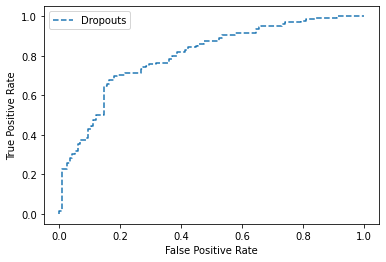

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6788321167883211
precision_true: 0.784688995215311
precision_fake: 0.6135693215339233
recall_true: 0.5559322033898305
recall_fake: 0.8221343873517787
f1score_true: 0.6507936507936508
f1score_fake: 0.7027027027027029
Binary_loss 0.572142
*******TEACHER*************
accuracy: 0.6605839416058394
precision_true: 0.7823834196891192
precision_fake: 0.5943661971830986
recall_true: 0.511864406779661
recall_fake: 0.83399209486166
f1score_true: 0.6188524590163934
f1score_fake: 0.694078947368421
Binary_loss 0.64622146
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7226277372262774
precision_true: 0.7544483985765125
precision_fake: 0.6891385767790262
recall_true: 0.7186440677966102
recall_fake: 0.7272727272727273
f1score_

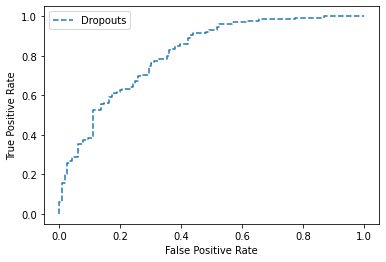

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.718978102189781
precision_true: 0.7079646017699115
precision_fake: 0.7368421052631579
recall_true: 0.8135593220338984
recall_fake: 0.6086956521739131
f1score_true: 0.7570977917981073
f1score_fake: 0.6666666666666666
Binary_loss 0.6795232
*******TEACHER*************
accuracy: 0.7098540145985401
precision_true: 0.7361111111111112
precision_fake: 0.6807692307692308
recall_true: 0.7186440677966102
recall_fake: 0.6996047430830039
f1score_true: 0.7272727272727273
f1score_fake: 0.6900584795321637
Binary_loss 0.53378105
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7098540145985401
precision_true: 0.7741935483870968
precision_fake: 0.6566666666666666
recall_true: 0.6508474576271186
recall_fake: 0.7786561264822134
f1s

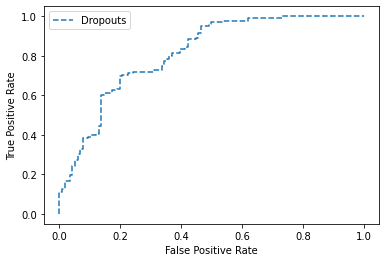

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7135036496350365
precision_true: 0.7254901960784313
precision_fake: 0.6983471074380165
recall_true: 0.752542372881356
recall_fake: 0.6679841897233202
f1score_true: 0.7387687188019967
f1score_fake: 0.6828282828282829
Binary_loss 0.8108364
*******TEACHER*************
accuracy: 0.7299270072992701
precision_true: 0.7378640776699029
precision_fake: 0.7196652719665272
recall_true: 0.7728813559322034
recall_fake: 0.6798418972332015
f1score_true: 0.7549668874172186
f1score_fake: 0.6991869918699187
Binary_loss 0.6233158
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7153284671532847
precision_true: 0.7491039426523297
precision_fake: 0.6802973977695167
recall_true: 0.7084745762711865
recall_fake: 0.7233201581027668
f1sc

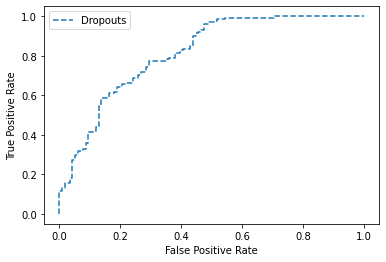

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7135036496350365
precision_true: 0.724025974025974
precision_fake: 0.7
recall_true: 0.7559322033898305
recall_fake: 0.6640316205533597
f1score_true: 0.7396351575456053
f1score_fake: 0.6815415821501014
Binary_loss 0.9001753
*******TEACHER*************
accuracy: 0.7171532846715328
precision_true: 0.7243589743589743
precision_fake: 0.7076271186440678
recall_true: 0.7661016949152543
recall_fake: 0.6600790513833992
f1score_true: 0.7446457990115322
f1score_fake: 0.6830265848670757
Binary_loss 0.76134866
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7098540145985401
precision_true: 0.7098765432098766
precision_fake: 0.7098214285714286
recall_true: 0.7796610169491526
recall_fake: 0.6284584980237155
f1score_true: 0.74

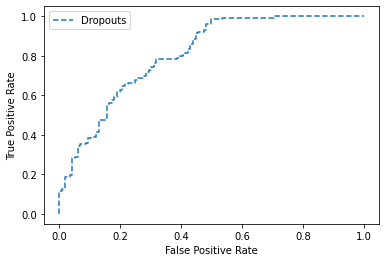

-----------------------------------------------------------------
train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1129 1060
Test Label count : True, Fake 130 114
Train Mean teacher Model...
26/26 [==============================] - 13s 497ms/step - loss: 0.6933 - accuracy: 0.4973
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.46897810218978103
precision_true: 0.0
precision_fake: 0.46897810218978103
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6385093167701864
Binary_loss 0.6923993
*******TEACHER*************
accuracy: 0.46897810218978103
precision_true: 0.0
precision_fake: 0.46897810218978103
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6385093167701864
Binary_loss 0.6930108
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.46897810218978103
precision_true: 0.0
precision_fake: 0.46897810218978103
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6385093167701864
Binary_loss 0.69212717
*******TEACHER*************
accuracy: 0.46897810218978103
precision_true: 0.0
precision_fake: 0.46897810218978103
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6385093167701864
Binary_loss 0.69309914
* * * * * * * * * * * * * * * * *
Start of epoch 3
*

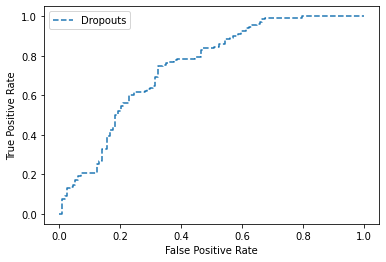

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6624087591240876
precision_true: 0.6177777777777778
precision_fake: 0.8673469387755102
recall_true: 0.9553264604810997
recall_fake: 0.33073929961089493
f1score_true: 0.7503373819163294
f1score_fake: 0.4788732394366197
Binary_loss 0.63728094
*******TEACHER*************
accuracy: 0.6295620437956204
precision_true: 0.8548387096774194
precision_fake: 0.5636792452830188
recall_true: 0.3642611683848797
recall_fake: 0.9299610894941635
f1score_true: 0.5108433734939759
f1score_fake: 0.7019089574155652
Binary_loss 0.6847439
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6642335766423357
precision_true: 0.6181015452538632
precision_fake: 0.8842105263157894
recall_true: 0.9621993127147767
recall_fake: 0.32684824902723736


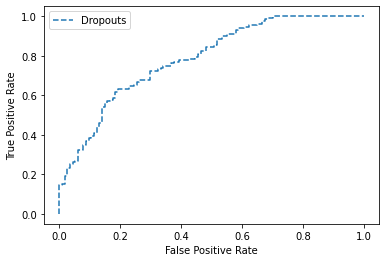

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6678832116788321
precision_true: 0.6235827664399093
precision_fake: 0.8504672897196262
recall_true: 0.9450171821305842
recall_fake: 0.3540856031128405
f1score_true: 0.7513661202185792
f1score_fake: 0.5
Binary_loss 0.6123237
*******TEACHER*************
accuracy: 0.6587591240875912
precision_true: 0.6192660550458715
precision_fake: 0.8125
recall_true: 0.9278350515463918
recall_fake: 0.3540856031128405
f1score_true: 0.7427785419532323
f1score_fake: 0.4932249322493225
Binary_loss 0.6253479
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6697080291970803
precision_true: 0.6227678571428571
precision_fake: 0.88
recall_true: 0.9587628865979382
recall_fake: 0.3424124513618677
f1score_true: 0.7550744248985114
f1score_fak

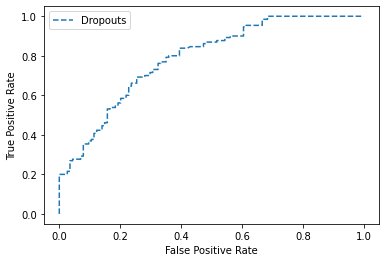

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6806569343065694
precision_true: 0.79
precision_fake: 0.617816091954023
recall_true: 0.5429553264604811
recall_fake: 0.8365758754863813
f1score_true: 0.6435845213849288
f1score_fake: 0.7107438016528925
Binary_loss 0.57044995
*******TEACHER*************
accuracy: 0.6733576642335767
precision_true: 0.625
precision_fake: 0.89
recall_true: 0.9621993127147767
recall_fake: 0.3463035019455253
f1score_true: 0.7577807848443842
f1score_fake: 0.4985994397759103
Binary_loss 0.5937299
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7025547445255474
precision_true: 0.7237762237762237
precision_fake: 0.6793893129770993
recall_true: 0.711340206185567
recall_fake: 0.6926070038910506
f1score_true: 0.7175043327556325
f1score_fake

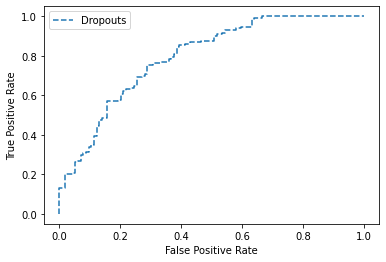

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6934306569343066
precision_true: 0.7617021276595745
precision_fake: 0.6421725239616614
recall_true: 0.6151202749140894
recall_fake: 0.7821011673151751
f1score_true: 0.6806083650190113
f1score_fake: 0.7052631578947368
Binary_loss 0.59275836
*******TEACHER*************
accuracy: 0.6879562043795621
precision_true: 0.8409090909090909
precision_fake: 0.6155913978494624
recall_true: 0.5085910652920962
recall_fake: 0.8910505836575876
f1score_true: 0.6338329764453962
f1score_fake: 0.7281399046104929
Binary_loss 0.56130755
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6952554744525548
precision_true: 0.69375
precision_fake: 0.6973684210526315
recall_true: 0.7628865979381443
recall_fake: 0.6186770428015564
f1score_true

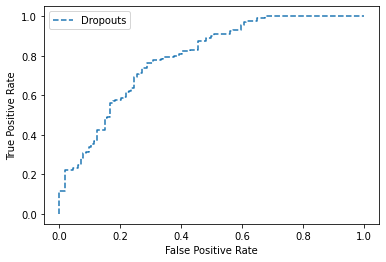

-----------------------------------------------------------------
train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1131 1058
Test Label count : True, Fake 128 116
Train Mean teacher Model...
26/26 [==============================] - 13s 500ms/step - loss: 0.6923 - accuracy: 0.5448
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5091240875912408
precision_true: 0.5196629213483146
precision_fake: 0.4895833333333333
recall_true: 0.6537102473498233
recall_fake: 0.35471698113207545
f1score_true: 0.5790297339593113
f1score_fake: 0.41137855579868704
Binary_loss 0.69207186
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4835766423357664
precision_true: 0.0
precision_fake: 0.4835766423357664
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6519065190651907
Binary_loss 0.6929334
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5127737226277372
precision_true: 0.5198019801980198
precision_fake: 0.4930555555555556
recall_true: 0.7420494699646644
recall_fake: 0.2679245283018868
f1score_true: 0.6113537117903931
f1score_fake: 0.34718826405867975
Binary_loss 0.69146997
*******TEACHER*************
accuracy: 0.4835766423357664
precision_true: 0.0
precision_fake: 0.4835766423357664
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6519065190651907
Binary_loss 0.69303894
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5401459854014599
precision_true: 0.5368171021377672
precision_fake: 0.5511811023622047
r

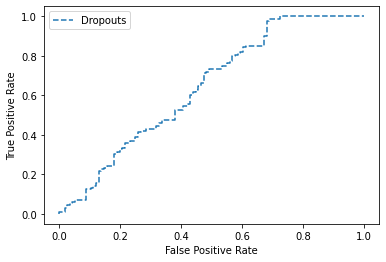

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6459854014598541
precision_true: 0.7069767441860465
precision_fake: 0.6066066066066066
recall_true: 0.5371024734982333
recall_fake: 0.7622641509433963
f1score_true: 0.6104417670682731
f1score_fake: 0.6755852842809364
Binary_loss 0.6008909
*******TEACHER*************
accuracy: 0.6222627737226277
precision_true: 0.5871559633027523
precision_fake: 0.7589285714285714
recall_true: 0.9045936395759717
recall_fake: 0.32075471698113206
f1score_true: 0.7121001390820584
f1score_fake: 0.4509283819628647
Binary_loss 0.6676092
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6697080291970803
precision_true: 0.6746575342465754
precision_fake: 0.6640625
recall_true: 0.696113074204947
recall_fake: 0.6415094339622641
f1score_true

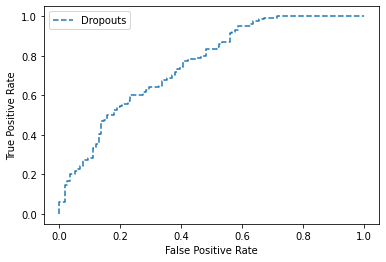

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6678832116788321
precision_true: 0.7130801687763713
precision_fake: 0.6334405144694534
recall_true: 0.5971731448763251
recall_fake: 0.7433962264150943
f1score_true: 0.65
f1score_fake: 0.6840277777777778
Binary_loss 0.86013967
*******TEACHER*************
accuracy: 0.6605839416058394
precision_true: 0.6130536130536131
precision_fake: 0.8319327731092437
recall_true: 0.9293286219081273
recall_fake: 0.37358490566037733
f1score_true: 0.7387640449438203
f1score_fake: 0.515625
Binary_loss 0.5904114
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6715328467153284
precision_true: 0.6914498141263941
precision_fake: 0.6523297491039427
recall_true: 0.657243816254417
recall_fake: 0.6867924528301886
f1score_true: 0.6739130434

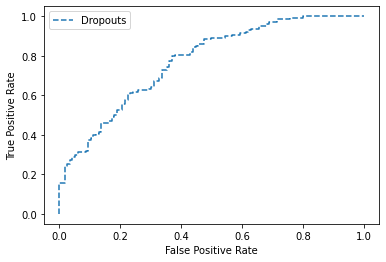

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6678832116788321
precision_true: 0.6797153024911032
precision_fake: 0.6554307116104869
recall_true: 0.6749116607773852
recall_fake: 0.660377358490566
f1score_true: 0.6773049645390071
f1score_fake: 0.6578947368421052
Binary_loss 1.0898131
*******TEACHER*************
accuracy: 0.6733576642335767
precision_true: 0.6768707482993197
precision_fake: 0.6692913385826772
recall_true: 0.7031802120141343
recall_fake: 0.6415094339622641
f1score_true: 0.6897746967071058
f1score_fake: 0.6551059730250482
Binary_loss 0.7590372
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6642335766423357
precision_true: 0.68
precision_fake: 0.6483516483516484
recall_true: 0.6607773851590106
recall_fake: 0.6679245283018868
f1score_true: 0.67

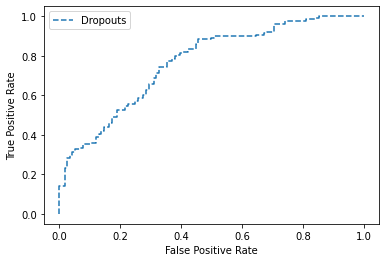

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.656934306569343
precision_true: 0.6752767527675276
precision_fake: 0.6389891696750902
recall_true: 0.6466431095406361
recall_fake: 0.6679245283018868
f1score_true: 0.6606498194945848
f1score_fake: 0.6531365313653137
Binary_loss 1.4468082
*******TEACHER*************
accuracy: 0.666058394160584
precision_true: 0.6865671641791045
precision_fake: 0.6464285714285715
recall_true: 0.6501766784452296
recall_fake: 0.6830188679245283
f1score_true: 0.6678765880217786
f1score_fake: 0.6642201834862386
Binary_loss 1.1181936
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.666058394160584
precision_true: 0.676056338028169
precision_fake: 0.6553030303030303
recall_true: 0.6784452296819788
recall_fake: 0.6528301886792452
f1score

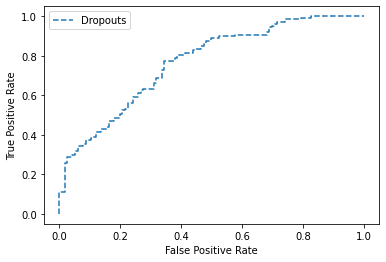

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1131 1059
Test Label count : True, Fake 128 115
Train Mean teacher Model...
26/26 [==============================] - 12s 472ms/step - loss: 0.6907 - accuracy: 0.5487
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5164233576642335
precision_true: 0.49767441860465117
precision_fake: 0.5847457627118644
recall_true: 0.8136882129277566
recall_fake: 0.24210526315789474
f1score_true: 0.6176046176046176
f1score_fake: 0.34243176178660056
Binary_loss 0.6959549
*******TEACHER*************
accuracy: 0.5072992700729927
precision_true: 0.49076517150395776
precision_fake: 0.5443786982248521
recall_true: 0.7072243346007605
recall_fake: 0.32280701754385965
f1score_true: 0.5794392523364486
f1score_fake: 0.4052863436123348
Binary_loss 0.6934623
* * * * * * * * * * * * * * *

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.5200729927007299
precision_true: 0.0
precision_fake: 0.5200729927007299
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6842737094837935
Binary_loss 0.69339675
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5437956204379562
precision_true: 0.5157384987893463
precision_fake: 0.6296296296296297
recall_true: 0.8098859315589354
recall_fake: 0.2982456140350877
f1score_true: 0.6301775147928994
f1score_fake: 0.40476190476190477
Binary_loss 0.69243795
*******TEACHER*************
accuracy: 0.5200729927007299
precision_true: 0.0
precision_fake: 0.5200729927007299
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6842737094837935
Binary_loss 0.69335735
* * * * * * * * * * * * * * * * *
Start of epoch 4
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5656934306569343
precision_true: 0.5292740046838408
precision_fake: 0.6942148760330579


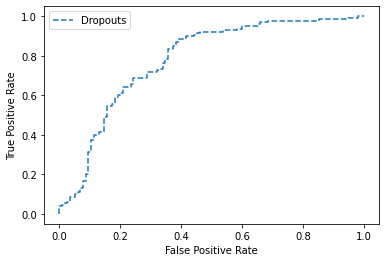

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6514598540145985
precision_true: 0.5983606557377049
precision_fake: 0.7582417582417582
recall_true: 0.8326996197718631
recall_fake: 0.4842105263157895
f1score_true: 0.6963434022257552
f1score_fake: 0.5910064239828694
Binary_loss 0.59815854
*******TEACHER*************
accuracy: 0.6751824817518248
precision_true: 0.6190476190476191
precision_fake: 0.7801047120418848
recall_true: 0.8403041825095057
recall_fake: 0.5228070175438596
f1score_true: 0.7129032258064516
f1score_fake: 0.6260504201680672
Binary_loss 0.64522934
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6751824817518248
precision_true: 0.6640926640926641
precision_fake: 0.6851211072664359
recall_true: 0.6539923954372624
recall_fake: 0.6947368421052632
f

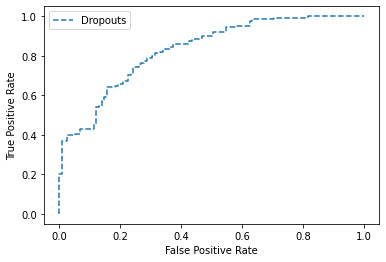

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6916058394160584
precision_true: 0.6654929577464789
precision_fake: 0.7196969696969697
recall_true: 0.7186311787072244
recall_fake: 0.6666666666666666
f1score_true: 0.6910420475319927
f1score_fake: 0.6921675774134791
Binary_loss 0.7065807
*******TEACHER*************
accuracy: 0.6824817518248175
precision_true: 0.6369230769230769
precision_fake: 0.7488789237668162
recall_true: 0.7870722433460076
recall_fake: 0.5859649122807018
f1score_true: 0.7040816326530612
f1score_fake: 0.6574803149606299
Binary_loss 0.54191506
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6788321167883211
precision_true: 0.6454849498327759
precision_fake: 0.7188755020080321
recall_true: 0.7338403041825095
recall_fake: 0.6280701754385964
f1

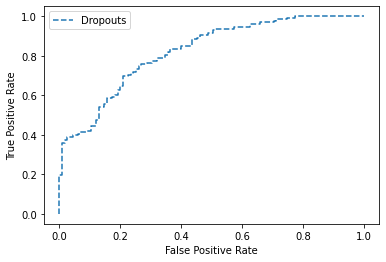

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6532846715328468
precision_true: 0.6852791878172588
precision_fake: 0.6353276353276354
recall_true: 0.5133079847908745
recall_fake: 0.7824561403508772
f1score_true: 0.5869565217391303
f1score_fake: 0.7012578616352202
Binary_loss 0.62045676
*******TEACHER*************
accuracy: 0.656934306569343
precision_true: 0.7329192546583851
precision_fake: 0.6253229974160207
recall_true: 0.44866920152091255
recall_fake: 0.8491228070175438
f1score_true: 0.5566037735849056
f1score_fake: 0.7202380952380953
Binary_loss 0.6137712
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6715328467153284
precision_true: 0.726775956284153
precision_fake: 0.6438356164383562
recall_true: 0.5057034220532319
recall_fake: 0.8245614035087719
f1s

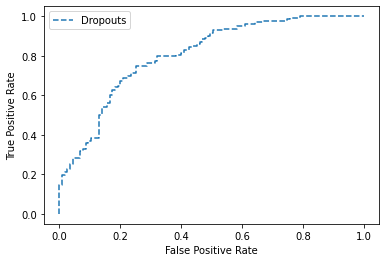

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6697080291970803
precision_true: 0.628125
precision_fake: 0.7280701754385965
recall_true: 0.7642585551330798
recall_fake: 0.5824561403508772
f1score_true: 0.6895368782161235
f1score_fake: 0.6471734892787524
Binary_loss 0.8184997
*******TEACHER*************
accuracy: 0.6587591240875912
precision_true: 0.6623931623931624
precision_fake: 0.6560509554140127
recall_true: 0.5893536121673004
recall_fake: 0.7228070175438597
f1score_true: 0.6237424547283703
f1score_fake: 0.687813021702838
Binary_loss 0.7083524
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6678832116788321
precision_true: 0.6216216216216216
precision_fake: 0.7395348837209302
recall_true: 0.7870722433460076
recall_fake: 0.5578947368421052
f1score_true: 

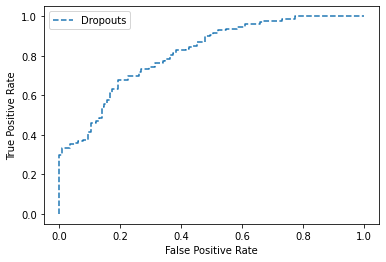

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1142 1048
Test Label count : True, Fake 117 126
Train Mean teacher Model...
26/26 [==============================] - 12s 470ms/step - loss: 0.6920 - accuracy: 0.5298
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5583941605839416
precision_true: 0.5927152317880795
precision_fake: 0.516260162601626
recall_true: 0.6006711409395973
recall_fake: 0.508
f1score_true: 0.5966666666666667
f1score_fake: 0.5120967741935484
Binary_loss 0.6903923
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4562043795620438
precision_true: 0.0
precision_fake: 0.4562043795620438
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6265664160401002
Binary_loss 0.69177014
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.572992700729927
precision_true: 0.5776699029126213
precision_fake: 0.5588235294117647
recall_true: 0.7986577181208053
recall_fake: 0.304
f1score_true: 0.6704225352112675
f1score_fake: 0.3937823834196891
Binary_loss 0.687304
*******TEACHER*************
accuracy: 0.4562043795620438
precision_true: 0.0
precision_fake: 0.4562043795620438
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6265664160401002
Binary_loss 0.6928064
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5693430656934306
precision_true: 0.5759803921568627
precision_fake: 0.55
recall_true: 0.7885906040268457


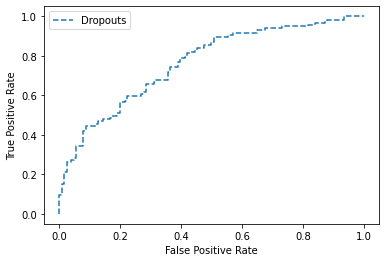

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6715328467153284
precision_true: 0.736
precision_fake: 0.6174496644295302
recall_true: 0.6174496644295302
recall_fake: 0.736
f1score_true: 0.6715328467153284
f1score_fake: 0.6715328467153284
Binary_loss 0.5792841
*******TEACHER*************
accuracy: 0.6405109489051095
precision_true: 0.8344370860927153
precision_fake: 0.5667506297229219
recall_true: 0.4228187919463087
recall_fake: 0.9
f1score_true: 0.5612472160356348
f1score_fake: 0.695517774343122
Binary_loss 0.6634584
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6751824817518248
precision_true: 0.8061224489795918
precision_fake: 0.6022727272727273
recall_true: 0.5302013422818792
recall_fake: 0.848
f1score_true: 0.6396761133603238
f1score_fake: 0.704318936

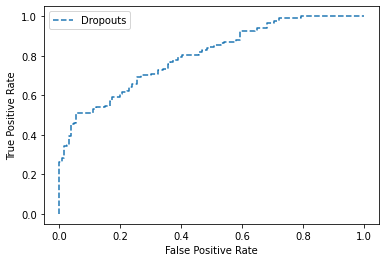

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7025547445255474
precision_true: 0.7288135593220338
precision_fake: 0.6719367588932806
recall_true: 0.7214765100671141
recall_fake: 0.68
f1score_true: 0.7251264755480606
f1score_fake: 0.6759443339960238
Binary_loss 0.60471815
*******TEACHER*************
accuracy: 0.7025547445255474
precision_true: 0.6880222841225627
precision_fake: 0.7301587301587301
recall_true: 0.8288590604026845
recall_fake: 0.552
f1score_true: 0.7519025875190259
f1score_fake: 0.6287015945330295
Binary_loss 0.5475165
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.708029197080292
precision_true: 0.6906077348066298
precision_fake: 0.7419354838709677
recall_true: 0.8389261744966443
recall_fake: 0.552
f1score_true: 0.7575757575757575
f1score_fa

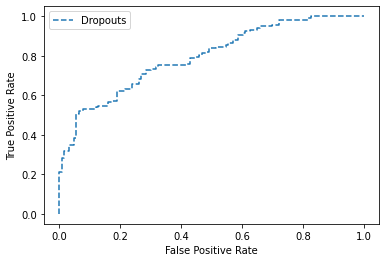

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6934306569343066
precision_true: 0.7321428571428571
precision_fake: 0.6529850746268657
recall_true: 0.6879194630872483
recall_fake: 0.7
f1score_true: 0.7093425605536332
f1score_fake: 0.6756756756756757
Binary_loss 0.6863673
*******TEACHER*************
accuracy: 0.708029197080292
precision_true: 0.6916666666666667
precision_fake: 0.7393617021276596
recall_true: 0.8355704697986577
recall_fake: 0.556
f1score_true: 0.756838905775076
f1score_fake: 0.634703196347032
Binary_loss 0.5992728
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7062043795620438
precision_true: 0.7107692307692308
precision_fake: 0.6995515695067265
recall_true: 0.7751677852348994
recall_fake: 0.624
f1score_true: 0.7415730337078652
f1score_fake: 

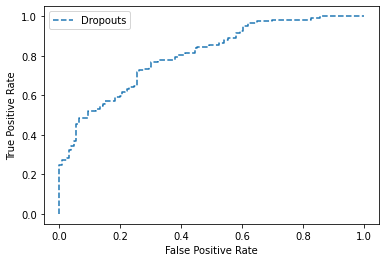

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6861313868613139
precision_true: 0.7350746268656716
precision_fake: 0.6392857142857142
recall_true: 0.6610738255033557
recall_fake: 0.716
f1score_true: 0.696113074204947
f1score_fake: 0.6754716981132075
Binary_loss 0.78670543
*******TEACHER*************
accuracy: 0.698905109489051
precision_true: 0.7180327868852459
precision_fake: 0.6748971193415638
recall_true: 0.7348993288590604
recall_fake: 0.656
f1score_true: 0.72636815920398
f1score_fake: 0.665314401622718
Binary_loss 0.68711954
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7098540145985401
precision_true: 0.7038123167155426
precision_fake: 0.7198067632850241
recall_true: 0.8053691275167785
recall_fake: 0.596
f1score_true: 0.7511737089201879
f1score_fake

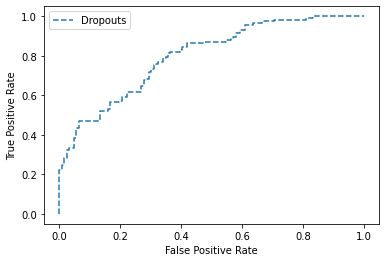

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1142 1048
Test Label count : True, Fake 117 126
Train Mean teacher Model...
26/26 [==============================] - 12s 455ms/step - loss: 0.6923 - accuracy: 0.5292
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5164233576642335
precision_true: 0.5223880597014925
precision_fake: 0.5
recall_true: 0.7420494699646644
recall_fake: 0.27547169811320754
f1score_true: 0.6131386861313869
f1score_fake: 0.35523114355231145
Binary_loss 0.692109
*******TEACHER*************
accuracy: 0.48722627737226276
precision_true: 0.5625
precision_fake: 0.4849624060150376
recall_true: 0.03180212014134275
recall_fake: 0.9735849056603774
f1score_true: 0.060200668896321065
f1score_fake: 0.6474278544542031
Binary_loss 0.69261545
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4835766423357664
precision_true: 0.0
precision_fake: 0.4835766423357664
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6519065190651907
Binary_loss 0.69289666
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5145985401459854
precision_true: 0.5213032581453634
precision_fake: 0.4966442953020134
recall_true: 0.734982332155477
recall_fake: 0.2792452830188679
f1score_true: 0.6099706744868035
f1score_fake: 0.35748792270531404
Binary_loss 0.68933326
*******TEACHER*************
accuracy: 0.4835766423357664
precision_true: 0.0
precision_fake: 0.4835766423357664
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6519065190651907
Binary_loss 0.6928391
* * * * * * * * * * * * * * * * *
Start of epoch 4
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5401459854014599
precision_true: 0.5378973105134475
precision_fake: 0.5467625899280576
re

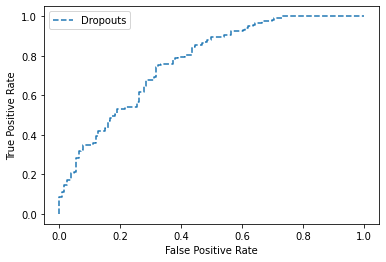

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6897810218978102
precision_true: 0.7424892703862661
precision_fake: 0.6507936507936508
recall_true: 0.6113074204946997
recall_fake: 0.7735849056603774
f1score_true: 0.6705426356589147
f1score_fake: 0.706896551724138
Binary_loss 0.5857667
*******TEACHER*************
accuracy: 0.6587591240875912
precision_true: 0.7330097087378641
precision_fake: 0.6140350877192983
recall_true: 0.5335689045936396
recall_fake: 0.7924528301886793
f1score_true: 0.6175869120654397
f1score_fake: 0.6919275123558486
Binary_loss 0.645138
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6952554744525548
precision_true: 0.7071428571428572
precision_fake: 0.6828358208955224
recall_true: 0.6996466431095406
recall_fake: 0.690566037735849
f1scor

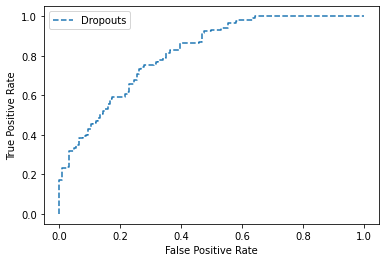

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6861313868613139
precision_true: 0.7302904564315352
precision_fake: 0.6514657980456026
recall_true: 0.6219081272084805
recall_fake: 0.7547169811320755
f1score_true: 0.6717557251908396
f1score_fake: 0.6993006993006993
Binary_loss 0.7226328
*******TEACHER*************
accuracy: 0.708029197080292
precision_true: 0.7220216606498195
precision_fake: 0.6937269372693727
recall_true: 0.7067137809187279
recall_fake: 0.7094339622641509
f1score_true: 0.7142857142857142
f1score_fake: 0.7014925373134329
Binary_loss 0.5602059
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6843065693430657
precision_true: 0.7052238805970149
precision_fake: 0.6642857142857143
recall_true: 0.6678445229681979
recall_fake: 0.7018867924528301
f1sc

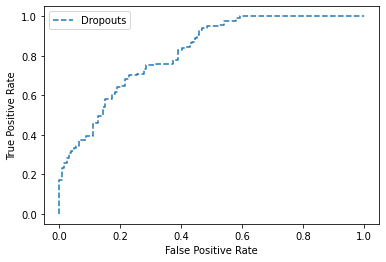

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6861313868613139
precision_true: 0.7126436781609196
precision_fake: 0.662020905923345
recall_true: 0.657243816254417
recall_fake: 0.7169811320754716
f1score_true: 0.6838235294117647
f1score_fake: 0.6884057971014492
Binary_loss 0.91392654
*******TEACHER*************
accuracy: 0.6824817518248175
precision_true: 0.6912280701754386
precision_fake: 0.6730038022813688
recall_true: 0.696113074204947
recall_fake: 0.6679245283018868
f1score_true: 0.6936619718309859
f1score_fake: 0.6704545454545454
Binary_loss 0.72001255
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6879562043795621
precision_true: 0.7121212121212122
precision_fake: 0.6654929577464789
recall_true: 0.6643109540636042
recall_fake: 0.7132075471698113
f1sc

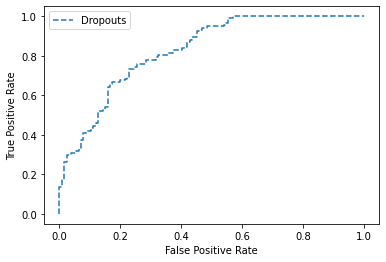

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6916058394160584
precision_true: 0.7021276595744681
precision_fake: 0.6804511278195489
recall_true: 0.6996466431095406
recall_fake: 0.6830188679245283
f1score_true: 0.7008849557522124
f1score_fake: 0.6817325800376647
Binary_loss 1.010804
*******TEACHER*************
accuracy: 0.6861313868613139
precision_true: 0.7018181818181818
precision_fake: 0.6703296703296703
recall_true: 0.6819787985865724
recall_fake: 0.690566037735849
f1score_true: 0.6917562724014338
f1score_fake: 0.6802973977695167
Binary_loss 0.9158321
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6934306569343066
precision_true: 0.7254901960784313
precision_fake: 0.6655290102389079
recall_true: 0.6537102473498233
recall_fake: 0.7358490566037735
f1sco

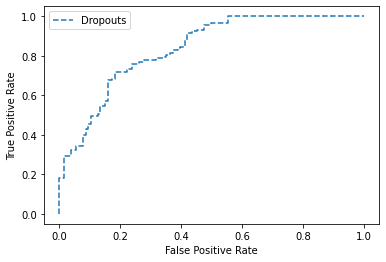

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1144 1046
Test Label count : True, Fake 115 128
Train Mean teacher Model...
26/26 [==============================] - 12s 471ms/step - loss: 0.6928 - accuracy: 0.5225
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5602189781021898
precision_true: 0.5830815709969789
precision_fake: 0.5253456221198156
recall_true: 0.652027027027027
recall_fake: 0.4523809523809524
f1score_true: 0.6156299840510367
f1score_fake: 0.4861407249466951
Binary_loss 0.6903352
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.45985401459854014
precision_true: 0.0
precision_fake: 0.45985401459854014
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.63
Binary_loss 0.69261193
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5802919708029197
precision_true: 0.5825
precision_fake: 0.5743243243243243
recall_true: 0.7871621621621622
recall_fake: 0.3373015873015873
f1score_true: 0.6695402298850575
f1score_fake: 0.42500000000000004
Binary_loss 0.6883229
*******TEACHER*************
accuracy: 0.45985401459854014
precision_true: 0.0
precision_fake: 0.45985401459854014
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.63
Binary_loss 0.69303495
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.572992700729927
precision_true: 0.5775
precision_fake: 0.5608108108108109
recall_true: 0.7804054054054054
recall_fake: 0.329

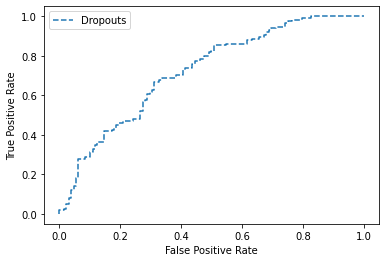

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7098540145985401
precision_true: 0.6985507246376812
precision_fake: 0.729064039408867
recall_true: 0.8141891891891891
recall_fake: 0.5873015873015873
f1score_true: 0.75195007800312
f1score_fake: 0.6505494505494505
Binary_loss 0.62927306
*******TEACHER*************
accuracy: 0.6879562043795621
precision_true: 0.7340823970037453
precision_fake: 0.6441281138790036
recall_true: 0.6621621621621622
recall_fake: 0.7182539682539683
f1score_true: 0.6962699822380106
f1score_fake: 0.6791744840525329
Binary_loss 0.6371322
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7007299270072993
precision_true: 0.7519083969465649
precision_fake: 0.6538461538461539
recall_true: 0.6655405405405406
recall_fake: 0.7420634920634921
f1sco

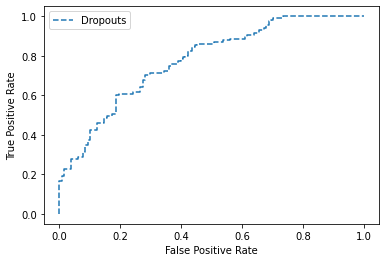

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.698905109489051
precision_true: 0.7133550488599348
precision_fake: 0.6804979253112033
recall_true: 0.7398648648648649
recall_fake: 0.6507936507936508
f1score_true: 0.7263681592039801
f1score_fake: 0.665314401622718
Binary_loss 0.7352092
*******TEACHER*************
accuracy: 0.6970802919708029
precision_true: 0.7462121212121212
precision_fake: 0.6514084507042254
recall_true: 0.6655405405405406
recall_fake: 0.7341269841269841
f1score_true: 0.7035714285714285
f1score_fake: 0.6902985074626866
Binary_loss 0.57879996
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6897810218978102
precision_true: 0.7333333333333333
precision_fake: 0.6474820143884892
recall_true: 0.668918918918919
recall_fake: 0.7142857142857143
f1sco

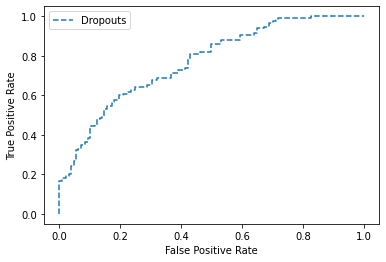

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6897810218978102
precision_true: 0.7299270072992701
precision_fake: 0.6496350364963503
recall_true: 0.6756756756756757
recall_fake: 0.7063492063492064
f1score_true: 0.7017543859649122
f1score_fake: 0.67680608365019
Binary_loss 0.8005277
*******TEACHER*************
accuracy: 0.7025547445255474
precision_true: 0.726962457337884
precision_fake: 0.6745098039215687
recall_true: 0.7195945945945946
recall_fake: 0.6825396825396826
f1score_true: 0.7232597623089982
f1score_fake: 0.6785009861932939
Binary_loss 0.70674855
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6952554744525548
precision_true: 0.7186440677966102
precision_fake: 0.6679841897233202
recall_true: 0.7162162162162162
recall_fake: 0.6706349206349206
f1sco

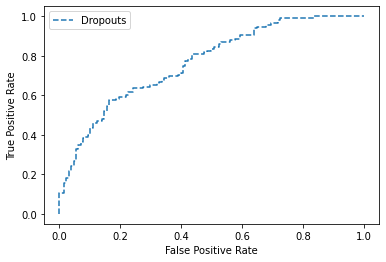

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6788321167883211
precision_true: 0.7222222222222222
precision_fake: 0.6366906474820144
recall_true: 0.6587837837837838
recall_fake: 0.7023809523809523
f1score_true: 0.6890459363957596
f1score_fake: 0.6679245283018869
Binary_loss 0.86511064
*******TEACHER*************
accuracy: 0.7025547445255474
precision_true: 0.7285223367697594
precision_fake: 0.6731517509727627
recall_true: 0.7162162162162162
recall_fake: 0.6865079365079365
f1score_true: 0.7223168654173764
f1score_fake: 0.6797642436149313
Binary_loss 0.7874517
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.698905109489051
precision_true: 0.7220338983050848
precision_fake: 0.6719367588932806
recall_true: 0.7195945945945946
recall_fake: 0.6746031746031746
f1s

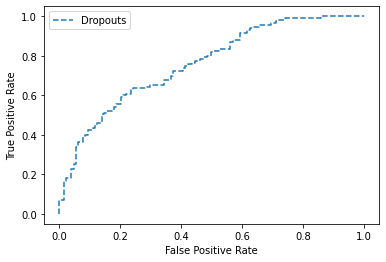

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1126 1064
Test Label count : True, Fake 133 110
Train Mean teacher Model...
26/26 [==============================] - 12s 478ms/step - loss: 0.6919 - accuracy: 0.5219
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5182481751824818
precision_true: 0.5068119891008175
precision_fake: 0.5414364640883977
recall_true: 0.6914498141263941
recall_fake: 0.35125448028673834
f1score_true: 0.5849056603773586
f1score_fake: 0.42608695652173906
Binary_loss 0.6928286
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.5091240875912408
precision_true: 0.0
precision_fake: 0.5091240875912408
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6747279322853688
Binary_loss 0.69304186
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5255474452554745
precision_true: 0.512
precision_fake: 0.5549132947976878
recall_true: 0.7137546468401487
recall_fake: 0.34408602150537637
f1score_true: 0.5962732919254657
f1score_fake: 0.4247787610619469
Binary_loss 0.69250655
*******TEACHER*************
accuracy: 0.5091240875912408
precision_true: 0.0
precision_fake: 0.5091240875912408
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6747279322853688
Binary_loss 0.69314945
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5456204379562044
precision_true: 0.5257731958762887
precision_fake: 0.59375
recall_true: 0.758364312

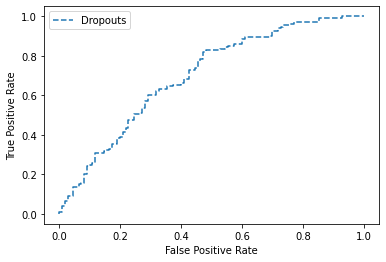

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7098540145985401
precision_true: 0.7806122448979592
precision_fake: 0.6704545454545454
recall_true: 0.5687732342007435
recall_fake: 0.8458781362007168
f1score_true: 0.6580645161290323
f1score_fake: 0.7480190174326465
Binary_loss 0.6137469
*******TEACHER*************
accuracy: 0.708029197080292
precision_true: 0.6847457627118644
precision_fake: 0.7351778656126482
recall_true: 0.7509293680297398
recall_fake: 0.6666666666666666
f1score_true: 0.7163120567375886
f1score_fake: 0.6992481203007518
Binary_loss 0.6589631
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6879562043795621
precision_true: 0.6331521739130435
precision_fake: 0.8
recall_true: 0.8661710037174721
recall_fake: 0.5161290322580645
f1score_true: 0.731

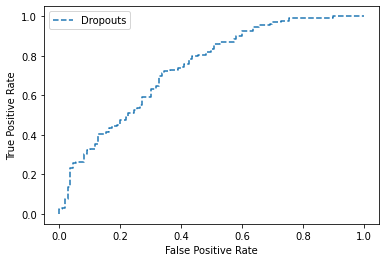

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7244525547445255
precision_true: 0.7122302158273381
precision_fake: 0.737037037037037
recall_true: 0.7360594795539034
recall_fake: 0.7132616487455197
f1score_true: 0.7239488117001829
f1score_fake: 0.7249544626593807
Binary_loss 0.6804831
*******TEACHER*************
accuracy: 0.7062043795620438
precision_true: 0.6776315789473685
precision_fake: 0.7418032786885246
recall_true: 0.7657992565055762
recall_fake: 0.6487455197132617
f1score_true: 0.719022687609075
f1score_fake: 0.6921606118546845
Binary_loss 0.55158883
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.708029197080292
precision_true: 0.7339055793991416
precision_fake: 0.6888888888888889
recall_true: 0.6356877323420075
recall_fake: 0.7777777777777778
f1sco

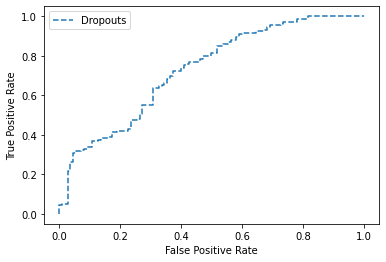

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.718978102189781
precision_true: 0.6923076923076923
precision_fake: 0.751004016064257
recall_true: 0.7695167286245354
recall_fake: 0.6702508960573477
f1score_true: 0.7288732394366196
f1score_fake: 0.7083333333333334
Binary_loss 0.7820277
*******TEACHER*************
accuracy: 0.6952554744525548
precision_true: 0.659375
precision_fake: 0.7456140350877193
recall_true: 0.7843866171003717
recall_fake: 0.6093189964157706
f1score_true: 0.7164685908319185
f1score_fake: 0.6706114398422091
Binary_loss 0.6638583
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7208029197080292
precision_true: 0.6933333333333334
precision_fake: 0.7540322580645161
recall_true: 0.7732342007434945
recall_fake: 0.6702508960573477
f1score_true: 0

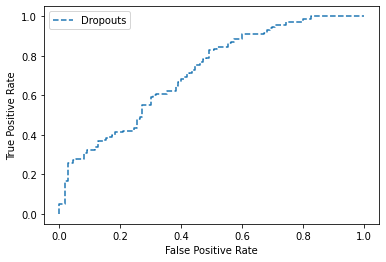

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.698905109489051
precision_true: 0.6756756756756757
precision_fake: 0.7261904761904762
recall_true: 0.7434944237918215
recall_fake: 0.6559139784946236
f1score_true: 0.7079646017699115
f1score_fake: 0.6892655367231638
Binary_loss 0.7806202
*******TEACHER*************
accuracy: 0.7043795620437956
precision_true: 0.6851211072664359
precision_fake: 0.7258687258687259
recall_true: 0.7360594795539034
recall_fake: 0.6738351254480287
f1score_true: 0.7096774193548386
f1score_fake: 0.6988847583643123
Binary_loss 0.7534895
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7171532846715328
precision_true: 0.7317073170731707
precision_fake: 0.7052980132450332
recall_true: 0.6691449814126395
recall_fake: 0.7634408602150538
f1sc

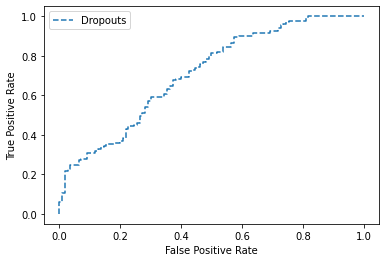

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1128 1062
Test Label count : True, Fake 131 112
Train Mean teacher Model...
26/26 [==============================] - 13s 481ms/step - loss: 0.6922 - accuracy: 0.5329
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5328467153284672
precision_true: 0.5482954545454546
precision_fake: 0.5051020408163265
recall_true: 0.6655172413793103
recall_fake: 0.38372093023255816
f1score_true: 0.6012461059190032
f1score_fake: 0.4361233480176211
Binary_loss 0.6910468
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.4708029197080292
precision_true: 0.0
precision_fake: 0.4708029197080292
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.640198511166253
Binary_loss 0.69232976
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5218978102189781
precision_true: 0.5380434782608695
precision_fake: 0.4888888888888889
recall_true: 0.6827586206896552
recall_fake: 0.34108527131782945
f1score_true: 0.601823708206687
f1score_fake: 0.4018264840182648
Binary_loss 0.68979275
*******TEACHER*************
accuracy: 0.4708029197080292
precision_true: 0.0
precision_fake: 0.4708029197080292
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.640198511166253
Binary_loss 0.6928289
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5273722627737226
precision_true: 0.5417789757412399
precision_fake: 0.4971751412429379
reca

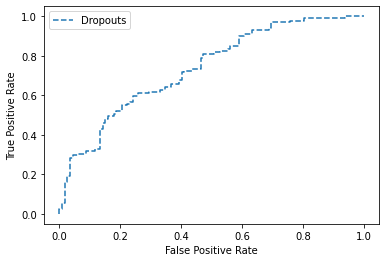

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7208029197080292
precision_true: 0.6779220779220779
precision_fake: 0.8220858895705522
recall_true: 0.9
recall_fake: 0.5193798449612403
f1score_true: 0.7733333333333334
f1score_fake: 0.6365795724465558
Binary_loss 0.53300864
*******TEACHER*************
accuracy: 0.708029197080292
precision_true: 0.7044025157232704
precision_fake: 0.7130434782608696
recall_true: 0.7724137931034483
recall_fake: 0.6356589147286822
f1score_true: 0.7368421052631577
f1score_fake: 0.6721311475409836
Binary_loss 0.6551647
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7135036496350365
precision_true: 0.6811989100817438
precision_fake: 0.7790055248618785
recall_true: 0.8620689655172413
recall_fake: 0.5465116279069767
f1score_true: 0.76

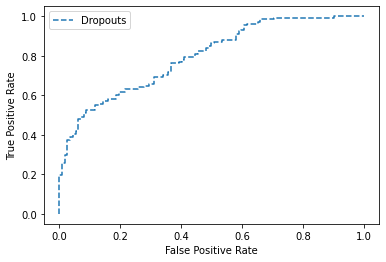

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6897810218978102
precision_true: 0.7631578947368421
precision_fake: 0.6375
recall_true: 0.6
recall_fake: 0.7906976744186046
f1score_true: 0.6718146718146718
f1score_fake: 0.7058823529411764
Binary_loss 0.62130207
*******TEACHER*************
accuracy: 0.7317518248175182
precision_true: 0.712166172106825
precision_fake: 0.7630331753554502
recall_true: 0.8275862068965517
recall_fake: 0.624031007751938
f1score_true: 0.7655502392344498
f1score_fake: 0.6865671641791045
Binary_loss 0.5098144
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.7135036496350365
precision_true: 0.7301038062283737
precision_fake: 0.694980694980695
recall_true: 0.7275862068965517
recall_fake: 0.6976744186046512
f1score_true: 0.7288428324697754

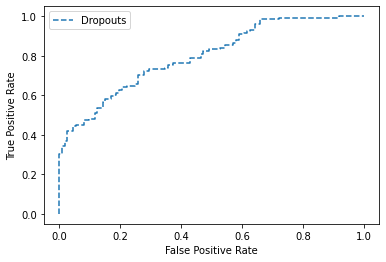

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.666058394160584
precision_true: 0.6578171091445427
precision_fake: 0.6794258373205742
recall_true: 0.7689655172413793
recall_fake: 0.5503875968992248
f1score_true: 0.7090620031796502
f1score_fake: 0.6081370449678801
Binary_loss 0.86073875
*******TEACHER*************
accuracy: 0.7153284671532847
precision_true: 0.6925287356321839
precision_fake: 0.755
recall_true: 0.8310344827586207
recall_fake: 0.5852713178294574
f1score_true: 0.7554858934169278
f1score_fake: 0.6593886462882096
Binary_loss 0.55550635
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6751824817518248
precision_true: 0.724
precision_fake: 0.6342281879194631
recall_true: 0.6241379310344828
recall_fake: 0.7325581395348837
f1score_true: 0.670370370370

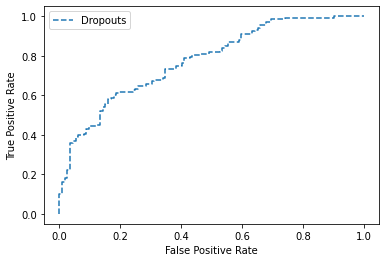

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6697080291970803
precision_true: 0.7582938388625592
precision_fake: 0.6142433234421365
recall_true: 0.5517241379310345
recall_fake: 0.8023255813953488
f1score_true: 0.6387225548902195
f1score_fake: 0.6957983193277311
Binary_loss 1.0466727
*******TEACHER*************
accuracy: 0.6970802919708029
precision_true: 0.7384615384615385
precision_fake: 0.6597222222222222
recall_true: 0.6620689655172414
recall_fake: 0.7364341085271318
f1score_true: 0.6981818181818182
f1score_fake: 0.6959706959706959
Binary_loss 0.703882
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6897810218978102
precision_true: 0.75
precision_fake: 0.6428571428571429
recall_true: 0.6206896551724138
recall_fake: 0.7674418604651163
f1score_true: 0.67

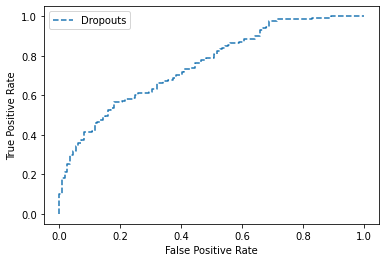

-----------------------------------------------------------------
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1127 1063
Test Label count : True, Fake 132 111
Train Mean teacher Model...
26/26 [==============================] - 12s 480ms/step - loss: 0.6931 - accuracy: 0.5195
* * * * * * * * * * * * * * * * *
Start of epoch 1
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5255474452554745
precision_true: 0.553763440860215
precision_fake: 0.511049723756906
recall_true: 0.3678571428571429
recall_fake: 0.6902985074626866
f1score_true: 0.44206008583690987
f1score_fake: 0.5873015873015873
Binary_loss 0.69190943
*******TEACHER*************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.48905109489051096
precision_true: 0.0
precision_fake: 0.48905109489051096
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6568627450980392
Binary_loss 0.69251966
* * * * * * * * * * * * * * * * *
Start of epoch 2
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5255474452554745
precision_true: 0.5259067357512953
precision_fake: 0.5246913580246914
recall_true: 0.725
recall_fake: 0.31716417910447764
f1score_true: 0.6096096096096096
f1score_fake: 0.39534883720930236
Binary_loss 0.69087696
*******TEACHER*************
accuracy: 0.48905109489051096
precision_true: 0.0
precision_fake: 0.48905109489051096
recall_true: 0.0
recall_fake: 1.0
f1score_true: 0.0
f1score_fake: 0.6568627450980392
Binary_loss 0.69311595
* * * * * * * * * * * * * * * * *
Start of epoch 3
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.5328467153284672
precision_true: 0.5307692307692308
precision_fake: 0.5379746835443038
recall_t

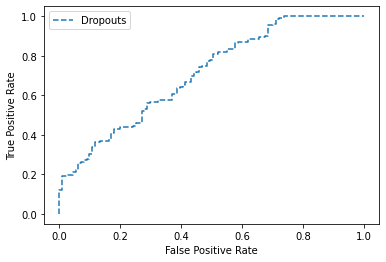

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 11
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6751824817518248
precision_true: 0.6583850931677019
precision_fake: 0.6991150442477876
recall_true: 0.7571428571428571
recall_fake: 0.5895522388059702
f1score_true: 0.7043189368770764
f1score_fake: 0.6396761133603238
Binary_loss 0.6518801
*******TEACHER*************
accuracy: 0.6478102189781022
precision_true: 0.6198347107438017
precision_fake: 0.7027027027027027
recall_true: 0.8035714285714286
recall_fake: 0.48507462686567165
f1score_true: 0.6998444790046656
f1score_fake: 0.5739514348785871
Binary_loss 0.6643514
* * * * * * * * * * * * * * * * *
Start of epoch 12
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6788321167883211
precision_true: 0.7015503875968992
precision_fake: 0.6586206896551724
recall_true: 0.6464285714285715
recall_fake: 0.7126865671641791
f1

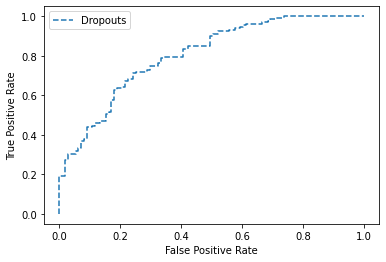

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 16
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6642335766423357
precision_true: 0.6690140845070423
precision_fake: 0.6590909090909091
recall_true: 0.6785714285714286
recall_fake: 0.6492537313432836
f1score_true: 0.673758865248227
f1score_fake: 0.6541353383458646
Binary_loss 0.70381254
*******TEACHER*************
accuracy: 0.6806569343065694
precision_true: 0.6881720430107527
precision_fake: 0.6728624535315985
recall_true: 0.6857142857142857
recall_fake: 0.6753731343283582
f1score_true: 0.6869409660107335
f1score_fake: 0.6741154562383613
Binary_loss 0.5680318
* * * * * * * * * * * * * * * * *
Start of epoch 17
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.666058394160584
precision_true: 0.6763636363636364
precision_fake: 0.6556776556776557
recall_true: 0.6642857142857143
recall_fake: 0.667910447761194
f1sco

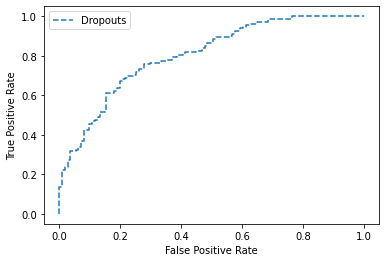

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 21
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6514598540145985
precision_true: 0.6394984326018809
precision_fake: 0.6681222707423581
recall_true: 0.7285714285714285
recall_fake: 0.5708955223880597
f1score_true: 0.6811352253756261
f1score_fake: 0.6156941649899397
Binary_loss 0.85289556
*******TEACHER*************
accuracy: 0.666058394160584
precision_true: 0.6579804560260586
precision_fake: 0.6763485477178424
recall_true: 0.7214285714285714
recall_fake: 0.6082089552238806
f1score_true: 0.6882453151618398
f1score_fake: 0.6404715127701376
Binary_loss 0.7002032
* * * * * * * * * * * * * * * * *
Start of epoch 22
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6642335766423357
precision_true: 0.6325966850828729
precision_fake: 0.7258064516129032
recall_true: 0.8178571428571428
recall_fake: 0.503731343283582
f1sc

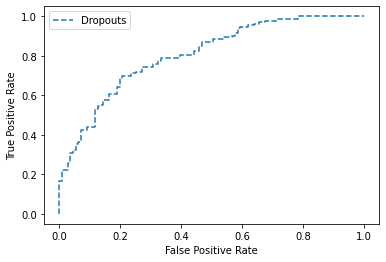

-----------------------------------------------------------------
* * * * * * * * * * * * * * * * *
Start of epoch 26
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6532846715328468
precision_true: 0.6371951219512195
precision_fake: 0.6772727272727272
recall_true: 0.7464285714285714
recall_fake: 0.5559701492537313
f1score_true: 0.6875
f1score_fake: 0.610655737704918
Binary_loss 0.872531
*******TEACHER*************
accuracy: 0.6642335766423357
precision_true: 0.6463414634146342
precision_fake: 0.6909090909090909
recall_true: 0.7571428571428571
recall_fake: 0.5671641791044776
f1score_true: 0.6973684210526315
f1score_fake: 0.6229508196721312
Binary_loss 0.81687427
* * * * * * * * * * * * * * * * *
Start of epoch 27
* * * * * * * * * * * * * * * * *
0.99
*******STUDENT*************
accuracy: 0.6697080291970803
precision_true: 0.6551724137931034
precision_fake: 0.6899563318777293
recall_true: 0.7464285714285714
recall_fake: 0.5895522388059702
f1score_true: 0.

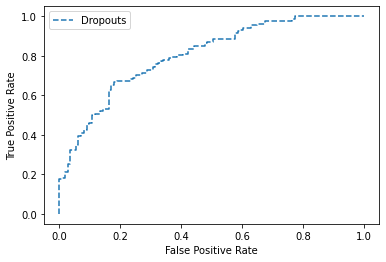

-----------------------------------------------------------------
finished


In [ ]:
from sklearn.model_selection import KFold
if __name__ == '__main__':
 

    # k fold function calling 
    lr=0.0001
    epochs=30
    batch_size= 64
    #for mean teacher 
    ratio =0.5
    alpha=0.99 #(0.90-0.99)
    maxlen=100
    n_split=10

    x_train, y_train, x_test, y_test, x_unlabel = loading_data()
    x_train, x_test, x_unlabel, vocab_size, tokenizer = tokenization(x_train,x_test, x_unlabel, maxlen)
    

    X = np.concatenate((x_train, x_test))
    Y = np.concatenate((y_train, y_test))
    
    for train_index,test_index in KFold(n_split).split(X):
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]
        print("train Data_Size:",  np.shape(x_train))
        print("test Data_Size:",  np.shape(x_test))
        print('Train Label count: True, Fake', np.count_nonzero(y_train==1),np.count_nonzero(y_train==0))
        print('Test Label count : True, Fake', np.count_nonzero(y_test==1),np.count_nonzero(y_test==0))
        meanteacher=train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel,vocab_size, tokenizer,maxlen)
        # model=train_supervised(epochs,batch_size,lr,x_train,y_train,x_test,y_test,maxlen,vocab_size)

        tf.keras.backend.clear_session()


    print('finished')